Loading model from fraud_detection_model.pkl...
Model loaded successfully.
Using Optimal Threshold: 0.9657
Loading test data from fraudTest.csv...
Processing data...
Predicting...

TEST RESULTS
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    553574
       Fraud       0.81      0.79      0.80      2145

    accuracy                           1.00    555719
   macro avg       0.91      0.90      0.90    555719
weighted avg       1.00      1.00      1.00    555719

ROC-AUC: 0.9980


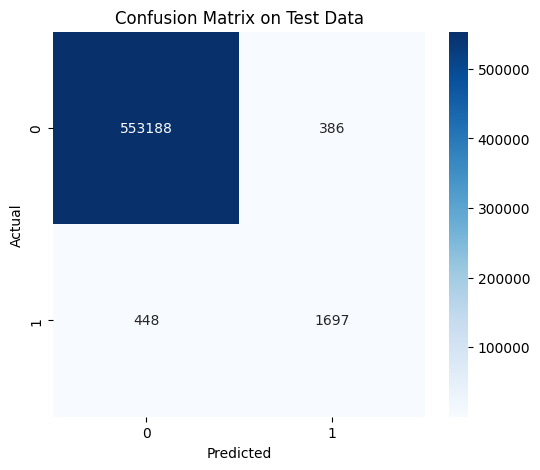

In [2]:
import pandas as pd
import numpy as np
import joblib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

warnings.filterwarnings('ignore')

# ============================================================================
# 1. CÁC HÀM XỬ LÝ DỮ LIỆU (PHẢI GIỐNG HỆT LÚC TRAIN)
# ============================================================================

def create_features(df):
    df = df.copy()
    # 1. Time
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['dob'] = pd.to_datetime(df['dob'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    df['month'] = df['trans_date_trans_time'].dt.month
    df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365
    
    # 2. Distance
    df['distance_km'] = np.sqrt(
        (df['lat'] - df['merch_lat'])**2 + (df['long'] - df['merch_long'])**2
    ) * 111
    
    # 3. Aggregations
    df['card_mean_amt'] = df.groupby('cc_num')['amt'].transform('mean')
    df['card_std_amt'] = df.groupby('cc_num')['amt'].transform('std')
    df['amt_zscore'] = (df['amt'] - df['card_mean_amt']) / (df['card_std_amt'] + 1e-5)
    df['card_trans_count'] = df.groupby('cc_num')['amt'].transform('count')
    df['category_mean_amt'] = df.groupby('category')['amt'].transform('mean')
    df['amt_vs_category_mean'] = df['amt'] / (df['category_mean_amt'] + 1e-5)
    
    # 4. Log
    df['amt_log'] = np.log1p(df['amt'])
    return df

def preprocess_data(df):
    df = create_features(df)
    
    drop_cols = ['trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 
                 'street', 'city', 'state', 'zip', 'dob', 'trans_num', 'unix_time',
                 'lat', 'long', 'merch_lat', 'merch_long', 'Unnamed: 0'] 
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])
    
    cat_cols = ['category', 'gender', 'job']
    for col in cat_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            
    import re
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    return df

# ============================================================================
# 2. MAIN: LOAD MODEL & PREDICT
# ============================================================================

if __name__ == "__main__":
    model_path = 'fraud_detection_model.pkl'
    test_csv_path = 'fraudTest.csv' # File bạn muốn test
    
    print(f"Loading model from {model_path}...")
    try:
        # 1. Load Model & Metadata
        saved_data = joblib.load(model_path)
        model = saved_data['model']
        threshold = saved_data['threshold']
        saved_features = saved_data['features']
        
        print(f"Model loaded successfully.")
        print(f"Using Optimal Threshold: {threshold:.4f}")
        
        # 2. Load & Preprocess Test Data
        print(f"Loading test data from {test_csv_path}...")
        df_test = pd.read_csv(test_csv_path)
        
        print("Processing data...")
        df_processed = preprocess_data(df_test)
        
        # Tách Label (nếu có) để đánh giá
        y_true = None
        if 'is_fraud' in df_processed.columns:
            y_true = df_processed['is_fraud']
            X_test = df_processed.drop('is_fraud', axis=1)
        else:
            X_test = df_processed
            
        # QUAN TRỌNG: Sắp xếp cột đúng thứ tự như lúc train
        # Nếu thiếu cột nào (do drop), code sẽ báo lỗi
        X_test = X_test[saved_features]
        
        # 3. Predict
        print("Predicting...")
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)
        
        # 4. Show Results
        if y_true is not None:
            print("\n" + "="*40)
            print("TEST RESULTS")
            print("="*40)
            print(classification_report(y_true, y_pred, target_names=['Normal', 'Fraud']))
            print(f"ROC-AUC: {roc_auc_score(y_true, y_prob):.4f}")
            
            # Vẽ Confusion Matrix
            cm = confusion_matrix(y_true, y_pred)
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix on Test Data')
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.show()
        else:
            print("\nPrediction complete.")
            df_test['fraud_probability'] = y_prob
            df_test['is_fraud_prediction'] = y_pred
            # Lưu kết quả ra file mới
            output_file = 'fraud_prediction_results.csv'
            df_test.to_csv(output_file, index=False)
            print(f"Results saved to {output_file}")

    except FileNotFoundError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()